In [1]:
import math
from datetime import date

# 😎 Manual inputs:
symbol                   = "KO" 
sigma                    = 0.14 
riskfree_rate            = math.e**(.0395)-1
date_today               = date(2023,2,28) 
date_expire              = date(2023,3,17) 

# Implementation

Developed in the previous notebook [BSM Part 2](https://github.com/kevinhhl/options-pricing-tools-and-trading-strategies/blob/main/Black_Scholes_Merton_Model_Part2_Position_Analysis.ipynb):

| Hierarchy & name of datatype | Description |
|--|--|
| Level 1: Contract| A datatype to store data points attributed to an individual option (ie. maturity date, strike price, call/put).  |
| Level 2: Leg | A data structure that stores (1) a single Contract (2) an instance of a BSM, and (3) the outputs from BSM|
| Level 3: Position | A collection of multiple Legs |





In [ ]:
!pip install yahoo_fin
from yahoo_fin import options

!pip install yfinance
import yfinance as yf

import time
import pandas as pd
from scipy.stats import norm

#### class BSM():

In [3]:
class BSM:
  
  def __init__(self, x, s,t,r,sigma):
    self.d1, self.d2 = None, None
    self.tv_call, self.delta_call , self.gamma_call, self.vega_call, self.theta_call, self.rho_call = None, None, None, None, None, None
    self.tv_put, self.delta_put, self.gamma_put, self.vega_put, self.theta_put, self.rho_put = None, None, None, None, None, None

    self.x = x
    self.s = s
    self.t = t
    self.r = r
    self.sigma = sigma
    self.calc()

  def calc(self):
    ''' Calculates all the theoretical and Greeks values for call and put. 
        Need to call calc() whenever new input is provided. 
    '''
    _a = math.log(self.s/ self.x)
    _b = (self.r+self.sigma**2/2)*self.t
    self.d1 = (_a+_b)/self.sigma*math.sqrt(self.t)
    self.d2 = self.d1 - self.sigma * math.sqrt(self.t)
    
    # Call: 
    self.tv_call    = self.s * norm.cdf(self.d1) - self.x*math.exp(-self.r*self.t)*norm.cdf(self.d2)
    self.delta_call = norm.cdf(self.d1)
    self.gamma_call = norm.pdf(self.d1)/(self.s*self.sigma*math.sqrt(self.t))
    self.vega_call  = 0.01*(self.s*norm.pdf(self.d1)*math.sqrt(self.t))
    self.theta_call = 0.01*(-(self.s*norm.pdf(self.d1)*self.sigma)/(2*math.sqrt(self.t)) - self.r*self.x*math.exp(-self.r*self.t)*norm.cdf(self.d2))
    self.rho_call   = 0.01*(self.x*self.t*math.exp(-self.r*self.t)*norm.cdf(self.d2))
    
    # Put: 
    self.tv_put    = self.x * math.exp(-self.r*self.t)-self.s+self.tv_call
    self.delta_put = -norm.cdf(-self.d1)
    self.gamma_put = norm.pdf(self.d1)/(self.s*self.sigma*math.sqrt(self.t))
    self.vega_put  = 0.01*(self.s*norm.pdf(self.d1)*math.sqrt(self.t))
    self.theta_put = 0.01*(-(self.s*norm.pdf(self.d1)*self.sigma)/(2*math.sqrt(self.t)) + self.r*self.x*math.exp(-self.r*self.t)*norm.cdf(-self.d2))
    self.rho_put   = 0.01*(-self.x*self.t*math.exp(-self.r*self.t)*norm.cdf(-self.d2))



#### class contract():

In [4]:
class contract:

  def __init__(self, expiry_date, strike, contracttype, quoted_price):
    self.multiple = 100
    self.strike = strike
    self.contracttype=contracttype
    self.expiry_date = expiry_date
    self.price = quoted_price

  def __str__(self):
    return "{}_{}_{} @{}".format(self.expiry_date, self.strike, self.contracttype, self.price)

#### class leg():

In [5]:
class leg:

  def __init__(self, side, contract, size, date_today, s,r,sigma):
    self.size=size
    leg.size = size
    self.side = side
    t = (contract.expiry_date-date_today).days/365
    self.contract = contract
    self.model = BSM(contract.strike, s,t,r,sigma)

    self.delta = None
    self.rho = None
    self.vega = None
    self.theta = None   
    self.gamma = None
    self.edge = 0
    self.premium = 0

    # int _coefficient, has three purposes:
    #   (1) +/-ve Delta for long call/put, but it's reversed from seller's perspective  
    #   (2) If buyer of contract:   +ve vega, -ve theta, +ve gamma
    #   (3) If seller of contract:  -ve vega, +ve theta, -ve gamma
    _coefficient = None
    if self.side == "long":
      _coefficient = 1
    elif self.side == "short":
      _coefficient = -1
    
    if contract.contracttype=="call":
      if self.side == "long":
        self.edge = (self.model.tv_call-self.contract.price) * size 
      elif self.side == "short":
        self.edge = (self.contract.price-self.model.tv_call) * size 
      self.delta = self.model.delta_call * size  * _coefficient
      self.rho = self.model.rho_call * size      * _coefficient
      self.vega = self.model.vega_call * size    * _coefficient
      self.gamma = self.model.gamma_call * size  * _coefficient
      self.theta = self.model.theta_call * size  * _coefficient
    
    elif contract.contracttype=="put":
      if self.side == "long":
        self.edge = (self.model.tv_put-self.contract.price) * size 
      elif self.side == "short":
        self.edge = (self.contract.price-self.model.tv_put) * size 
      self.delta = self.model.delta_put * size   * _coefficient
      self.rho = self.model.rho_put * size       * _coefficient
      self.vega = self.model.vega_put * size     * _coefficient
      self.gamma = self.model.gamma_put * size   * _coefficient
      self.theta = self.model.theta_put * size   * _coefficient
    
    self.premium = contract.price * size * -_coefficient

  def __str__(self):
    n_round= 4 
    return "{} [x{}]: Δ={},𝚪={},Θ={},V={},⍴={}".format(str(self.contract),self.size, \
      self.delta.round(n_round),self.gamma.round(n_round),self.theta.round(n_round),self.vega.round(n_round),self.rho.round(n_round))


### class position():

In [6]:
class position:

  def __init__(self):
    self.list_leg = []
    
    self.total_delta = 0
    self.total_gamma = 0
    self.total_vega = 0
    self.total_theta = 0
    self.total_rho = 0
    self.total_premium = 0
    self.total_th_edge = 0

  def get_summary(self, rounding=4) -> dict:
    ''' Returns dict of {string:float}
    '''
    return {"Total delta" : round(self.total_delta,rounding),
            "Total gamma" : round(self.total_gamma,rounding),
            "Total vega"  : round(self.total_vega,rounding),
            "Total theta" : round(self.total_theta,rounding),
            "Total rho"   :round(self.total_rho,rounding),
            "Premium (paid)/received" : round(self.total_premium,rounding),
            "Th. Edge"    : round(self.total_th_edge,rounding),
            }
  
  def add_leg(self, leg):
    ''' @param leg
    '''
    size = leg.size
    self.total_premium += leg.premium
    self.total_th_edge += leg.edge
    self.list_leg.append(leg)
    
    self.total_delta += leg.delta
    self.total_gamma += leg.gamma
    self.total_vega += leg.vega
    self.total_theta += leg.theta
    self.total_rho += leg.rho 


### Other Methods :

Including code blocks for processing data

In [7]:
def populate_dict(yf_chain, contracttype):
  ''' @param Object yf_chain : from options.get_options_chain(symbol, date_expire_str)["calls" or "puts"]
      @param string contracttype : either "call" or "put
      Returns a dict of {float strike price : contract object}
  '''
  out = {}
  for i in range(len(yf_chain)):
    x = yf_chain["Strike"][i]
    out[x] = contract(date_expire, x, contracttype, yf_chain["Last Price"][i])
  return out


In [8]:
ttm = (date_expire-date_today).days/365

# Confirming that the expiration date is valid.
exp_dates = options.get_expiration_dates(symbol)
date_expire_str = date_expire.strftime("%B %d, %Y") 
assert date_expire_str in exp_dates 

# Obtaining the recent close priceticker_yahoo = yf.Ticker(symbol)
ticker_yahoo = yf.Ticker(symbol)
data = ticker_yahoo.history()
crnt_price = data['Close'].iloc[-1]
crnt_price.round(2)
original_chain_call = options.get_options_chain(symbol, date_expire_str)["calls"]
original_chain_put = options.get_options_chain(symbol, date_expire_str)["puts"]

calls = populate_dict(original_chain_call, "call")
puts = populate_dict(original_chain_put, "put")

#Application: 

In [9]:
pos = position()
# 😎 Manual inputs:
# Example: Buying a straddle
leg1 = leg(side="long", contract=populate_dict(original_chain_call, "call")[60], size=1, date_today=date_today, s=crnt_price, r=riskfree_rate, sigma=sigma)
leg2 = leg(side="long", contract=puts[60], size=1, date_today=date_today, s=crnt_price, r=riskfree_rate, sigma=sigma)
pos.add_leg(leg1)
pos.add_leg(leg2)



#Sensitivity Analysis 

###Option's value v. Spot price

Theoretical edge exists when price of underlying
 asset is out of price interval (55.63, 64.01)


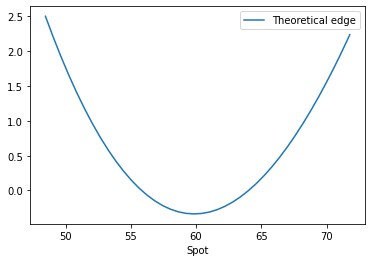

In [10]:
step_spot = crnt_price*.01
list_x, list_y = [], []
list_zerocross = []
__tmp = None

for i in range(-20,20):
  _spot = crnt_price-i*step_spot

  tmp_pos = position() 
  for e in pos.list_leg:
    _leg = leg(side=e.side, contract=e.contract, size=e.size, date_today=date_today, s=_spot, r=riskfree_rate, sigma=sigma)
    tmp_pos.add_leg(_leg)
  
  list_x.append(_spot)
  _edge = tmp_pos.total_th_edge 
  if __tmp is not None and ((_edge > 0 and __tmp < 0) or (_edge < 0 and __tmp > 0)):
    list_zerocross.append(_spot.round(2))
  list_y.append(_edge)
  __tmp = _edge

pd.DataFrame({ "Spot":list_x, "Theoretical edge":list_y} ).plot(x="Spot", y="Theoretical edge" )
list.sort(list_zerocross)
print("Theoretical edge exists when price of underlying\n asset is out of price interval " + str(tuple(list_zerocross)) )

###Option's value v. Sigma when ATM

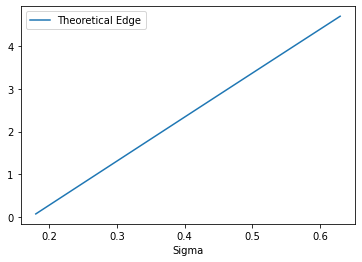

In [11]:
step_sigma = .01
list_x, list_y = [], []

for i in range(-10,50):
  _sigma = sigma + i*step_sigma
  tmp_pos = position() 

  tmp_pos = position() 
  for e in pos.list_leg:
    _leg = leg(side=e.side, contract=e.contract, size=e.size, date_today=date_today, s=crnt_price, r=riskfree_rate, sigma=_sigma)
    tmp_pos.add_leg(_leg)

  list_x.append(_sigma)
  list_y.append(tmp_pos.total_th_edge)

df = pd.DataFrame({ "Sigma":list_x, "Theoretical Edge":list_y } )
df = df[df["Theoretical Edge"]>0] 
df.plot(x="Sigma", y="Theoretical Edge");

Based on this plot:

> **Interpretation #1:** As Buyer of the straddle, we want volatility to increase to around 0.2. If all other variables are constant, then our Long straddle will begin to have a theoretical edge. 

> **Interpretation #2:** As Seller of the straddle, being on the opposite side, we want volatility to sit still. When the options expire out of the money, we as the seller won't get assigned to fulfilling the terms of the contracts, premiums previously received become crystalized profits. For this to happen, it's best to see volatility being as low as possible. If implied volatility increases to 0.2, then it is a red flag from the seller's perspective. 

###Option's value v. Sigma when deeply ITM

As seen in the previous example, when strike price is near-the-money, the curve (Theoretical value based on f(Sigma)) is very close to being a straight line. However, the curvature becomes more evident when the option is deeply in/out of the money. 

To illustrate the point, suppose price tanks by 50%. As buyer of straddle who already owns the position, the best case scenario is for volatility to stay low until expiration when the 60 put becomes exercisable.

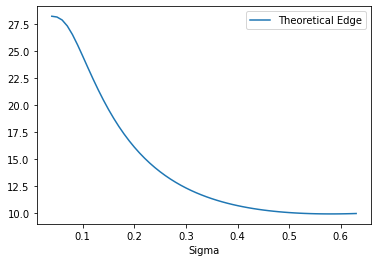

In [12]:
step_sigma = .01
list_x, list_y = [], []

for i in range(-10,50):
  _sigma = sigma + i*step_sigma
  tmp_pos = position() 

  tmp_pos = position() 
  for e in pos.list_leg:
    _leg = leg(side=e.side, contract=e.contract, size=e.size, date_today=date_today, s=crnt_price/2, r=riskfree_rate, sigma=_sigma)
    tmp_pos.add_leg(_leg)

  list_x.append(_sigma)
  list_y.append(tmp_pos.total_th_edge)

df = pd.DataFrame({ "Sigma":list_x, "Theoretical Edge":list_y } )
df = df[df["Theoretical Edge"]>0] 
df.plot(x="Sigma", y="Theoretical Edge");

###Delta v. Spot price

In a perfect world, a straddle is delta neutral when both calls and puts are at-the-money and have Deltas of +/- 50s (+/- 50s cancel out). 

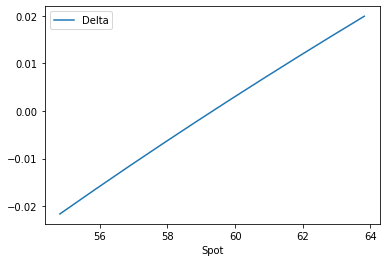

In [13]:
step_spot = 1
list_x, list_y = [], []

for i in range(-5,5):
  _spot = crnt_price + i*step_spot
  tmp_pos = position() 

  tmp_pos = position() 
  for e in pos.list_leg:
    _leg = leg(side=e.side, contract=e.contract, size=e.size, date_today=date_today, s=_spot, r=riskfree_rate, sigma=_sigma)
    tmp_pos.add_leg(_leg)

  list_x.append(_spot)
  list_y.append(tmp_pos.total_delta)

df = pd.DataFrame({ "Spot":list_x, "Delta":list_y } ) 
df.plot(x="Spot", y="Delta");

>**Interpretations:** As spot prices make a steady move below/above 60 (Using the word "steady" because we are holding vega constant) we get exposed to delta, just a little bit of delta. 

Here, we see it is impractical to strive for Delta neutrality in this position. If price makes a steady rise by 5, or a steady fall by 5, then adjustments will be to buy/sell underlying 2 shares; PL effects will likely be inconsequential. 

In principle, it makes sense that the Delta of this position (a straddle) is not sensitive to price change. When calls and puts are ATM, their deltas are approx. +/- 50s, canceling out net delta. The plot tells us we are close enough to being delta neutral.
